In [2]:
# pip install tensorflow_hub

In [3]:
# pip install tf-nightly

In [4]:
# pip install pyyaml h5py

In [5]:
import itertools
import os
from PIL import Image

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import keras
# from keras.utils import image_dataset_from_directory

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Matplotlib is building the font cache; this may take a moment.


TF version: 2.3.4
Hub version: 0.12.0
GPU is available


In [6]:
model_name = "resnet50" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet50":"https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
}

model_image_size_map = {}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 1024

Selected model: resnet50 : https://tfhub.dev/tensorflow/resnet_50/feature_vector/1
Input size (224, 224)


In [8]:
# class_names = os.listdir('/home/ec2-user/SageMaker/wikiart_post/train')
# data_dir = '/home/ec2-user/SageMaker/wikiart_post/train'
data_dir = '/home/ec2-user/SageMaker/wikiart_styles_224'

In [9]:
def build_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

In [10]:
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

Found 56800 files belonging to 14 classes.
Using 45440 files for training.


In [11]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

In [12]:
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
    preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
    preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

In [13]:
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))


Found 56800 files belonging to 14 classes.
Using 11360 files for validation.


In [14]:
do_fine_tuning = False

In [15]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/tensorflow/resnet_50/feature_vector/1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                28686     
Total params: 23,589,838
Trainable params: 28,686
Non-trainable params: 23,561,152
_________________________________________________________________


In [16]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [17]:
train_size = 56800- 11360
valid_size = 11360

In [18]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE

In [19]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [43]:
model.load_weights('saved_model/')

In [45]:
hist = model.fit(
    train_ds,
    epochs=1, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[cp_callback]).history

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  Failed to allocate memory for the batch of component 0
	 [[node IteratorGetNext (defined at <ipython-input-26-3855c0f9095f>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  Failed to allocate memory for the batch of component 0
	 [[node IteratorGetNext (defined at <ipython-input-26-3855c0f9095f>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_60628]

Function call stack:
train_function -> train_function


In [38]:
model.evaluate(val_ds, batch_size=BATCH_SIZE)

12/12 [==============================] - 66s 6s/step - loss: 1.4845 - accuracy: 0.5948


[1.4844679832458496, 0.5948063135147095]

In [39]:
model.save_weights('saved_model/')

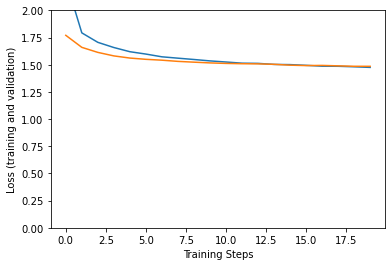

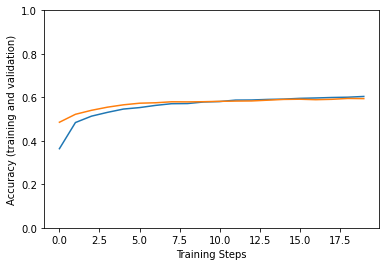

In [27]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

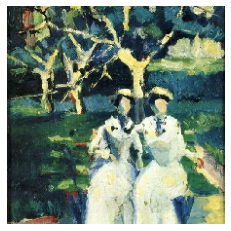

True label: Impressionism
Predicted label: Impressionism


In [31]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [23]:
# weights = model.save_weights("model.h5")


In [24]:
# loaded_weights = model.load_weights("model.h5")
#

In [35]:
model.save('resnet_styles')

INFO:tensorflow:Assets written to: resnet_styles/assets


INFO:tensorflow:Assets written to: resnet_styles/assets


In [142]:
loaded_weights

In [124]:
%load_ext tensorboard
import csv
import numpy as np
import tensorflow as tf
from PIL import Image

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [125]:
embeddings = tf.keras.models.Model( 
    inputs=model.inputs, 
    outputs=model.layers[-1].output 
)

In [126]:
def get_img(img_path):
    img = tf.io.read_file(img_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size for your model
    img = tf.image.resize_with_pad(img, 100, 100)
    return img

In [127]:
img_path[0]

'/'

In [128]:
# get_img(img_path[0])

In [129]:
# Generate embeddings
images_pil = []
images_embeddings = []
labels = []
data_dir = '/home/ec2-user/SageMaker/wikiart_styles_224'

In [130]:
raw_val_ds = []
lst = os.listdir(data_dir)

for i in range(len(lst)):
    folder = os.path.join(data_dir,lst[i])
    files = os.listdir(folder)
    for j in range(len(files)):
        path = os.path.join(folder,files[j])
        raw_val_ds.append([path,lst[i]])


In [133]:
for x in raw_val_ds: 
#     print(x)
    img_path = x[0]
#     print(img_path)
    img_tf = get_img(img_path)
#     print(img_tf)
    # Save both tf image for prediction and PIL image for sprite
    img_pil = Image.open(img_path).resize((100, 100))
    img_embedding = embeddings(tf.expand_dims(img_tf, axis=0))
#     images_embeddings.append(img_embedding.numpy()[0])
#     images_pil.append(img_pil)
#     # Assuming your output data is directly the label
#     label = x[1] 
#     labels.append(label)

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * Tensor("inputs:0", shape=(1, 100, 100, 3), dtype=float32)
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * False
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * True
    * None
  Keyword arguments: {}

In [42]:
imported = tf.saved_model.load("resnet_styles")

In [43]:
imported

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f32f6d859e8>

In [44]:
imported = tf.saved_model.load("resnet_styles")
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * Tensor("inputs:0", shape=(), dtype=float32)
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * True
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4')
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4')
    * False
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * False
    * None
  Keyword arguments: {}

In [30]:
saved_model_path = "resnet_styles"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: resnet_styles/assets


INFO:tensorflow:Assets written to: resnet_styles/assets


In [87]:
from tensorflow.keras.models import model_from_json

import tensorflow_hub as hub
import h5py

In [88]:
model.save('resnet_styles.h5')

In [90]:
model_new = model.load_weights('resnet_styles.h5')

In [45]:
new_model = tf.keras.models.load_model('resnet_styles.h5')

ValueError: Unknown layer: KerasLayer

In [93]:
model_new

In [91]:
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('resnet_styles.h5')

In [94]:
new_model = tf.keras.models.load_model(
    'resnet_styles.h5',
    custom_objects={'Functional':tf.keras.models.Model})

ValueError: Unknown layer: KerasLayer

In [92]:
# Show the model architecture
model_new.summary()

AttributeError: 'NoneType' object has no attribute 'summary'